# Mean meteorological variables calculation

In [1]:
import numpy as np
import pandas as pd
import fiona 
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
import geopandas as gpd
from cartopy import crs
from cartopy.io import shapereader
import xarray as xr 
import salem
from glob import glob
import seaborn as sns

import sys
sys.path.insert(1, '../src/')
import scripts
%matplotlib inline

In [2]:
with open('../src/data/COVID/minsalud_api') as url:
    url = url.read()
    data_coronavirus = pd.read_json(url)

In [3]:
from rasterio import features as _features
from affine import Affine as _Affine
import numpy as _np
import xarray as _xr

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an _Affine transformation
    """
    lat = _np.asarray(lat)
    lon = _np.asarray(lon)
    trans = _Affine.translation(lon[0], lat[0])
    scale = _Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale



def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=_np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise _np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (_Affine._Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio._features.rasterize fill the values
      outside the .shp file with _np.nan
    :spatial_coords (dict): dictionary of {"X":_xr.DataArray, "Y":_xr.DataArray()}
      with "X", "Y" as keys, and _xr.DataArray as values

    returns:
    -------
    :(_xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = _features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return _xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=_np.nan) 
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')

    return xr_da

In [79]:
def prepare_GOES(path):
    ds = xr.open_dataset(path)
    ds['longitudes'] = ds.longitudes[0]
    ds['latitudes'] = ds.latitudes[:, 0]
    ds = ds.set_coords(['longitudes', 'latitudes'])
    ds.attrs['pyproj_srs'] = 'epsg:4326'
    ds = ds.rename({'longitudes':'longitude', 'latitudes':'latitude'})
    ds = ds.swap_dims({'x':'longitude', 'y':'latitude'})
    return ds

def prepare_IMERG_tiff(path):
    ds = xr.open_rasterio(path)
    ds = ds.rename({'x':'longitude', 'y':'latitude'})
    return ds

def prepare_UVtermis(path):
    ds = xr.open_dataset(path)
    ds = ds.rename({'Latitudes':'latitude', 'Longitudes':'longitude'})
    ds = ds.swap_dims({'fakeDim0':'latitude', 'fakeDim1':'longitude'})
    ds = ds.set_coords(['longitude', 'latitude'])
    ds.attrs['pyproj_srs'] = 'epsg:4326'
    ds['UVI_field'] = ds.UVI_field * ds.UVI_scale_factor
    return ds

In [5]:
shp_dir = '../src/data/vector/departamentos_colombia.shp'
shp = salem.read_shapefile(shp_dir)
shp.Name = ['Bolivar', 'Boyaca', 'Caldas', 'Caqueta', 'Cauca', 'Cesar', 'Cordoba', 'Cundinamarca', 'Choco', 'Huila', 'La Guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander', 'Quindio', 'Risaralda', 'Santander', 'Sucre', 'Tolima', 'Valle del Cauca', 'Arauca', 'Casanare', 'Putumayo', 'San Andres y Providencia', 'Amazonas', 'Guainia', 'Guaviare', 'Vaupes', 'Vichada', 'NN', 'Antioquia', 'Atlantico', 'Bogota']
nombres_mascara = shp.Name

# BT GOES

In [6]:
paths = glob('../src/data/GOES/brightness_temperature/*nc')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[0]
ds = prepare_GOES(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mascara = ds_masked.departamentos

for path in paths[:]:
    
    ds = prepare_GOES(path)
    
    for id_municipio in nombres_mascara.index:
        select = ds.where(mascara == id_municipio, other=np.nan).bt_promedio.values
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('_')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

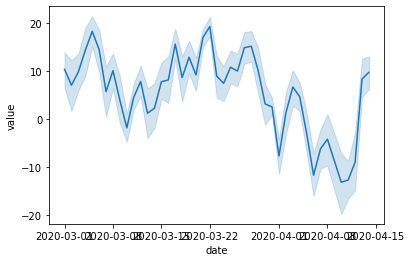

In [7]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [9]:
data_meteo.to_csv('../src/data/series/GOES_bt.csv')

# Cloud cover

In [10]:
paths = glob('../src/data/GOES/cloud_cover/*nc')
paths = [path for path in paths if len(path) < max([len(path) for path in paths])]

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_GOES(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [11]:
for path in paths[1:]:
    ds = prepare_GOES(path)
    
    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan).porcentaje.values
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('_')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

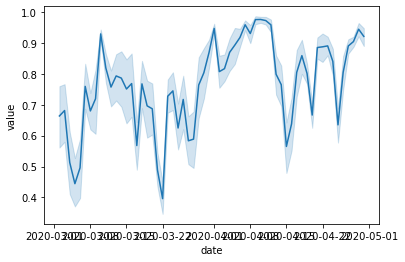

In [12]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [13]:
data_meteo.to_csv('../src/data/series/GOES_cc.csv')

# IMERG

In [18]:
paths = glob('../src/data/IMERG/*tiff')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_IMERG_tiff(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [19]:
for path in paths[:]:
    ds = prepare_IMERG_tiff(path)
    
    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan).values
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('_')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

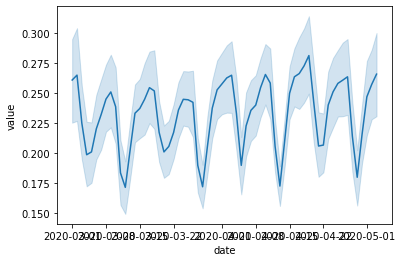

In [20]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [21]:
data_meteo.to_csv('../src/data/series/IMERG.csv')

# ERA 5

In [105]:
data_meteo = {var:pd.DataFrame(columns = nombres_mascara.values) for var in ['t2m_max', 't2m_min', 't2m_mean', 'ssr_sum', 'ssr_mean', 'uv_mean']}
ds = xr.open_dataset('../src/data/ERA5/ERA5_desccarga.nc')

for var in ds.data_vars:
     ds[var][744:, 0, :, :] = ds[var][744:, 1, :, :] 

ds['time'] = ds['time'] - pd.Timedelta('5h')


In [106]:
dates = pd.to_numeric(pd.to_datetime(ds['time'][:].values).strftime('%Y%m%d'))

In [107]:
#create mask
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [108]:
operation = ['nanmax', 'nanmin', 'nanmean', 'nansum', 'nanmean', 'nanmean']
data_vars = ['t2m', 't2m', 't2m', 'ssr', 'ssr', 'uv']

In [ ]:
np.warnings.filterwarnings('ignore')

for var, oper in zip(data_vars, operation):
    print(var)
    for date in dates.unique():
#         print(date)
        for id_municipio in nombres_mascara.index:
            
            if var != 'uv':
                select = getattr(np, oper)(ds.where(mask == id_municipio, other=np.nan)[var][np.where(dates == date)[0], 0, :, :].values, axis = 0)
                select = select[np.isfinite(select)]

                if len(select) > 0:
                    mean = np.nanmean(select)
                else:
                    mean = np.nan
            
            elif var == 'uv': 
                select = np.nanmean(np.sqrt(ds.where(mask == id_municipio, other=np.nan)['u10'][np.where(dates == date)[0], 0, :, :].values**2 + ds.where(mask == id_municipio, other=np.nan)['v10'][np.where(dates == date)[0], 0, :, :].values**2), axis = 0)
                select = select[np.isfinite(select)]

                if len(select) > 0:
                    mean = np.nanmean(select)
                else:
                    mean = np.nan
                    
            data_meteo[var + '_' + oper.replace('nan', '')].loc[pd.to_datetime(str(date)), nombres_mascara[id_municipio]] = mean

t2m
t2m


# UV Temis

In [80]:
ds = prepare_UVtermis(path)

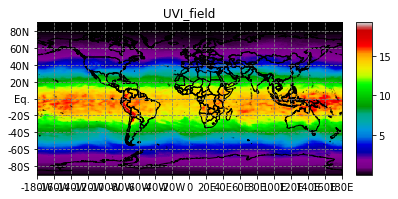

In [86]:
ds.UVI_field.salem.quick_map(cmap = plt.cm.nipy_spectral)

In [87]:
paths = glob('../src/data/UV_Temis/*.h5')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_UVtermis(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [ ]:
%%time
for path in paths[:]:
    ds = prepare_UVtermis(path)

    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan).UVI_field.values
#         select = select.astype(float)
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('uvief')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

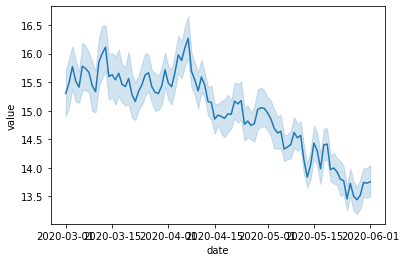

In [100]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [101]:
data_meteo.to_csv('../src/data/series/UV.csv')

### Descarga de UV Temis

In [42]:
base_url = 'http://www.temis.nl/uvradiation/archives/v2.0/{year}/{month}/uvief{date}.hdf'
dates_uv = pd.date_range('2020-03-01', '2020-06-01', freq = 'd')

for date in dates_uv:
    print(base_url.format(year = date.strftime('%Y'), month = date.strftime('%m'), date = date.strftime('%Y%m%d')))

In [3]:
for Departamento in data.departamento.unique():
    try:
        now = datetime.datetime.now()

        if Departamento == 'Colombia':
          print('En Colombia hay: ')
          select_department = data
          select_department_tipo_Imp = data.loc[(data['tipo']=='Importado')]
          select_department_tipo = data.loc[(data['tipo']!='Importado')]
          select_department_fallec = data.loc[(data['atenci_n'] =='Fallecido')]
          select_department_recup = data.loc[(data['atenci_n'] =='Recuperado')]
          select_department_hospit = data.loc[(data['atenci_n'] =='Hospital')]
          select_department_UCI = data.loc[(data['atenci_n'] =='Hospital UCI')]
          select_department_En_Casa = data.loc[(data['atenci_n'] =='Casa')]
        else:
          select_department = data.loc[data['departamento'] == Departamento]
          select_department_tipo_Imp = data.loc[(data['departamento'] == Departamento) & (data['tipo']=='Importado')]
          select_department_tipo = data.loc[(data['departamento'] == Departamento) & (data['tipo']!='Importado')]
          select_department_fallec = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Fallecido')]
          select_department_recup = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Recuperado')]
          select_department_hospit = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Hospital')]
          select_department_UCI = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Hospital UCI')]
          select_department_En_Casa = data.loc[(data['departamento'] == Departamento) & (data['atenci_n'] =='Casa')]
          print('En departamento de ' + Departamento + ' hay: ')

        dates_diaf = data.loc[(data['fis'] =='Asintomático')].to_numpy()
        if dates_diaf.size>0 :
          data.loc[(data['fis'] =='Asintomático'),['fis']] = dates_diaf[:,1]
          data.fis = pd.to_datetime(data.fis)

        df = select_department_tipo.groupby(by='fis').count()
        df_array = df.to_numpy()
        NI_infected_cases = df_array[:,0]
        Total_NI_infected_cases = np.cumsum(NI_infected_cases,0)
        time_vector = pd.to_datetime(df.index)
        #time_vector = datetime(df.index.to_numpy()).fromisoformat()
        tv = (time_vector-time_vector[0])
        cumulcases = Total_NI_infected_cases-Total_NI_infected_cases[0]+1

        Rtraw = 14.0*np.diff(np.log(cumulcases))+1
        Rfilt = sgnl.filtfilt([0.3333, 0.3333, 0.3333],[1.0],Rtraw)


        rt.loc[time_vector.date[1:], Departamento] = Rtraw
        rt_s.loc[time_vector.date[1:], Departamento] = Rfilt

    except:pass

In [ ]:
def rt():

In [4]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [5]:
poligonos = gpd.read_file('../src/data/vector/departamentos_colombia.kml', driver='KML')

*"El número básico de reproducción (R0), pretende ser un indicador del contagio o transmisibilidad de agentes infecciosos y parasitarios. R0 se encuentra a menudo en la bibliografía de epidemiología y salud pública y también se puede encontrar en la prensa popular. R0 se ha descrito como una de las métricas fundamentales y más utilizadas para el estudio de la dinámica de las enfermedades infecciosas. Un R0 para un evento de enfermedad infecciosa generalmente se informa como un valor numérico único o rango bajo-alto, y la interpretación generalmente se presenta como directa; se espera que continúe un brote si R0 tiene un valor >1  y que termine si R0 es  <1 . El tamaño potencial de un brote o epidemia a menudo se basa en la magnitud del valor R0 para ese evento, y R0 puede usarse para estimar la proporción de la población que debe vacunarse para eliminar una infección de esa población"* Tomado de: Delamater PL, Street EJ, Leslie TF, Yang Y, Jacobsen KH. Complexity of the Basic Reproduction Number (R0). Emerg Infect Dis. 2019;25(1):1-4. https://dx.doi.org/10.3201/eid2501.171901